### Notebook for Supplementary section 2. Regression analyses incorporating contextual factors 

In [1]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import os.path 
import hddm
#import statsmodels.api as sm
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
from patsy import center
%matplotlib inline 
cmap = sns.color_palette("hls", 8)
sns.set_palette(cmap)
sns.set_style("white")
import kabuki


In [2]:
# test parallel
import ipyparallel as ipp
c = ipp.Client()
c.ids
c[:].apply_sync(lambda : "test")

['test', 'test', 'test', 'test']

In [2]:
data = pd.read_csv('/home/Projects/scenestats/SCCE_allparticipants.csv') 
data.head(10)

,Unnamed: 0,Pic,dier,Sc,lmh,SpAc,response,rt,subj_idx,CE,SC,CE_c,SC_c,CE_squared,SC_squared,coverage,centrality
0,11837,325,D,3,high,Sp,0,0.019,ppn2,0.735808,1.427897,0.295828,0.503673,0.087514,0.253686,0.022692,93.220710
1,6811,122,nD,1,low,Sp,0,0.027,ppn17,0.181963,0.638774,-0.258017,-0.285450,0.066573,0.081482,0.000000,0.000000
2,12810,458,nD,3,high,Sp,1,0.029,ppn3,0.677126,1.216256,0.237146,0.292031,0.056238,0.085282,0.000000,0.000000
3,11515,102,nD,1,low,Sp,0,0.031,ppn2,0.191920,0.587651,-0.248060,-0.336574,0.061534,0.113282,0.000000,0.000000
4,12662,231,D,2,med,Sp,1,0.042,ppn3,0.420153,0.975979,-0.019828,0.051755,0.000393,0.002679,0.080417,91.676496
5,16222,25,D,1,low,Sp,0,0.048,ppn7,0.189681,0.715695,-0.250299,-0.208530,0.062649,0.043485,0.078464,83.679539
6,10792,182,D,2,med,Sp,1,0.076,ppn20,0.391657,0.904854,-0.048323,-0.019371,0.002335,0.000375,0.581556,48.731394
7,11481,27,D,1,low,Sp,1,0.079,ppn2,0.199897,0.660886,-0.240083,-0.263338,0.057640,0.069347,0.031602,34.166672
8,9533,428,nD,3,high,Ac,0,0.081,ppn19,0.601830,1.171586,0.161850,0.247362,0.026196,0.061188,0.000000,0.000000
9,12527,83,nD,1,low,Sp,1,0.082,ppn3,0.180269,0.682262,-0.259711,-0.241962,0.067450,0.058546,0.000000,0.000000


Adding these covariates:
['v_Intercept', 'v_SC_c', 'v_SC_squared', 'v_coverage', 'v_centrality']
 [-----------------100%-----------------] 10001 of 10000 complete in 14006.9 secWARNING: Will not save custom link functions.
Plotting a(Ac)
Plotting a(Sp)
Plotting a_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_SC_c
Plotting v_SC_squared
Plotting v_coverage
Plotting v_centrality


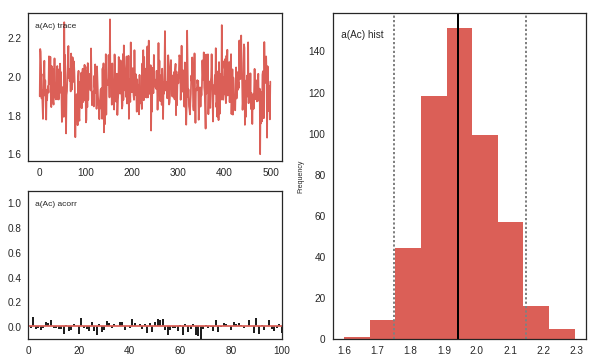

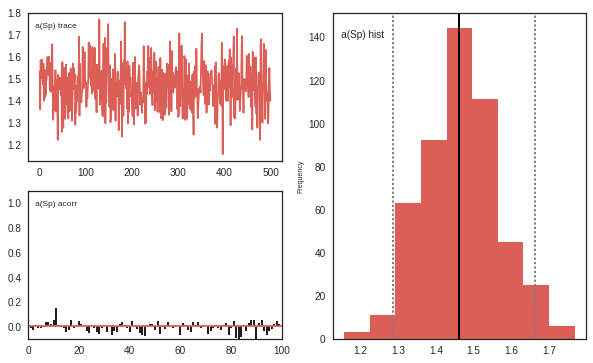

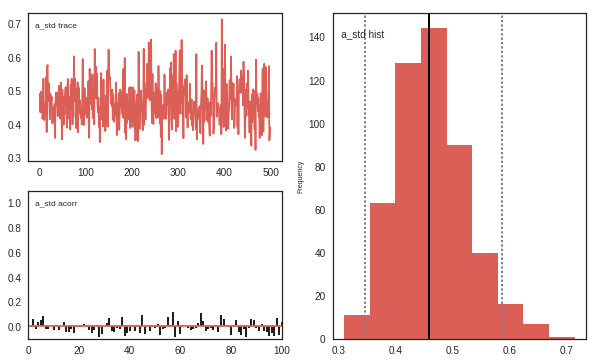

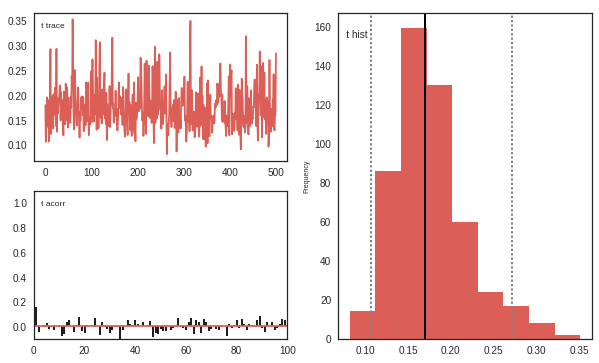

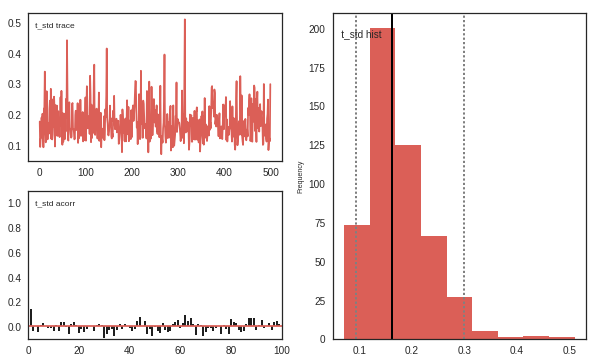

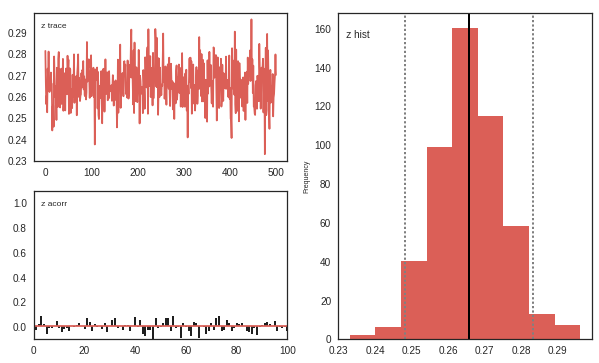

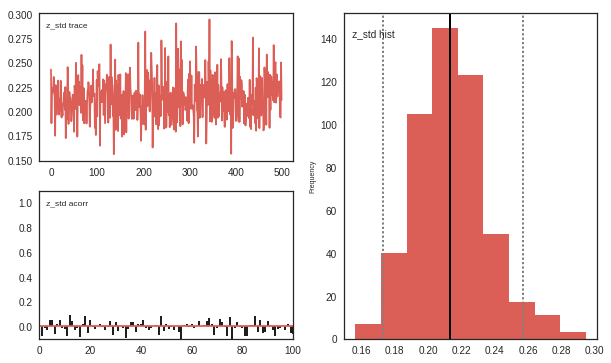

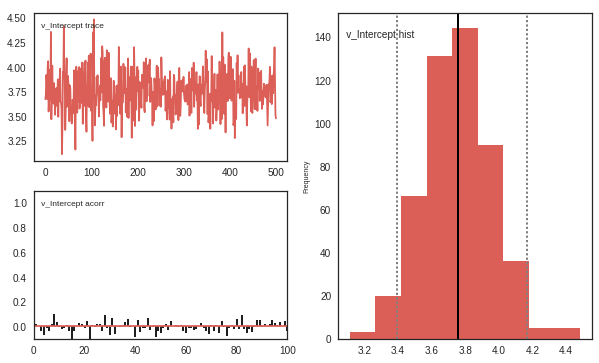

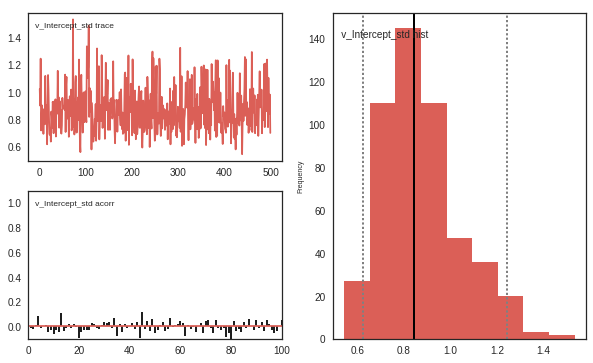

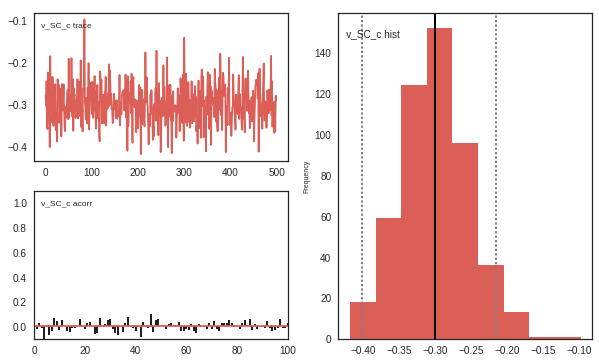

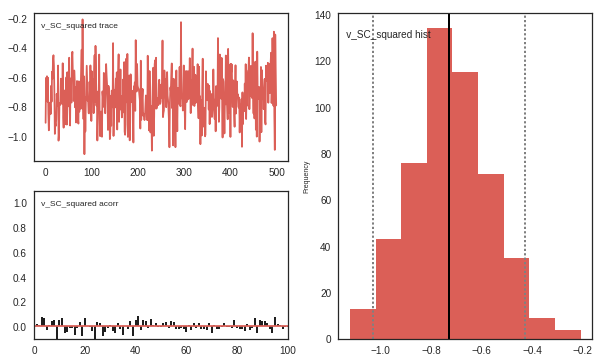

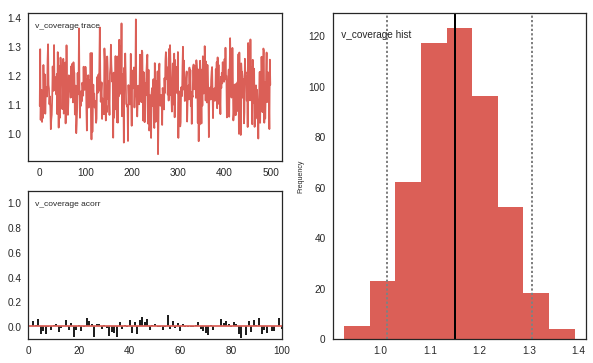

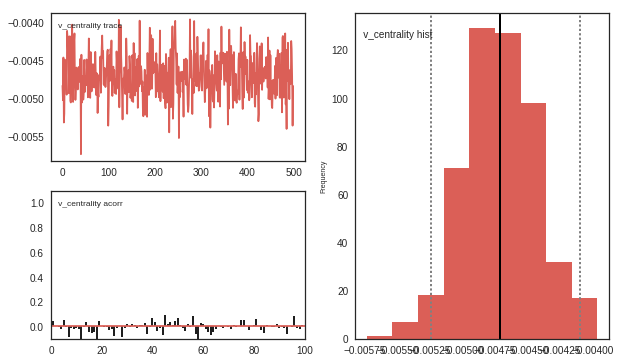

In [4]:
data = hddm.load_csv('/home//Projects/scenestats//SCCE_allparticipants.csv') 
    
reg = ['v ~ 1 + SC_c + SC_squared + coverage + centrality']
    
os.chdir(u'/home/Projects/scenestats/context/exp1')
m = hddm.HDDMRegressor(data, reg, depends_on={'a':'SpAc'},bias=True,include={'z'}, p_outlier=0.05)
m.find_starting_values()
m.sample(10000, burn=5000, thin=10, dbname='mtraces.db', db='pickle')

m.save('m')
m.plot_posteriors(save=True)
m.print_stats('printstats.txt')


In [6]:
# Load best model
os.chdir('/home//Projects/scenestats/context/exp1')
model = hddm.load('m')
print model.dic

-14964.8313463


[0.0, 0.0, 0.0, 0.0]


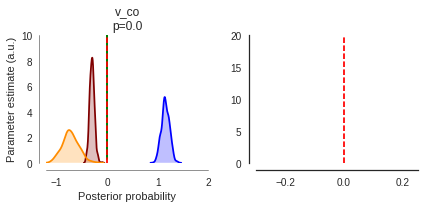

In [9]:
fig_dir = u'/home//Projects/scenestats/context/exp1'
params_of_interest = ['v_SC_c', 'v_SC_squared', 'v_centrality', 'v_coverage']
titles = ['v ~ SC', 'v ~ SC2', 'v_cent', 'v_co']

traces = []
for p in range(len(params_of_interest)):
    traces.append(model.nodes_db.node[params_of_interest[p]].trace.gettrace())

stats = []
for p in range(len(params_of_interest)):
    stat = min(np.mean(traces[p] > 0), np.mean(traces[p] < 0))
    stats.append(min(stat, 1-stat))
#stats = np.array(stats)    

print stats
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

ax_nr = 0
pl = 0
cc=['maroon','darkorange', 'green', 'blue', 'maroon', 'darkorange', 'green', 'blue']
for p in range(len(params_of_interest)):
    data = [traces[p]]
    ax = axes[ax_nr]
    for d, label, c in zip(data, ['1',], ['black']):
        sns.kdeplot(d, vertical=False, shade=True, color=cc[pl], ax=ax)
        ax.set_xlabel('Posterior probability')
        ax.set_title('{}\np={}'.format(titles[pl], round(stats[p],3)))
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
            ax.tick_params(width=0.5)          
        pl+=1
        if pl == 4:
            ax_nr+=1

        
sns.despine(offset=7, trim=False)
axes[0].set_ylabel('Parameter estimate (a.u.)')
axes[0].axvline(x=0, color='r', linestyle='--')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[0].set_ylim(0,10)
axes[0].set_xlim(-1.2,2)
axes[1].set_ylim(0,20)
axes[1].set_xlim(-0.3,0.25)

plt.tight_layout()
fig.savefig(os.path.join(fig_dir, 'posteriors.pdf'))

Adding these covariates:
['v_Intercept', 'v_SC_c', 'v_SC_squared', 'v_coverage', 'v_centrality']
Adding these covariates:
['a_Intercept', 'a_SC_c', 'a_SC_squared', 'a_coverage', 'a_centrality']
 [-----------------100%-----------------] 10001 of 10000 complete in 40495.3 secWARNING: Will not save custom link functions.
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_SC_c
Plotting v_SC_squared
Plotting v_coverage
Plotting v_centrality
Plotting a_Intercept(Ac)
Plotting a_Intercept(Sp)
Plotting a_Intercept_std
Plotting a_SC_c
Plotting a_SC_squared
Plotting a_coverage
Plotting a_centrality


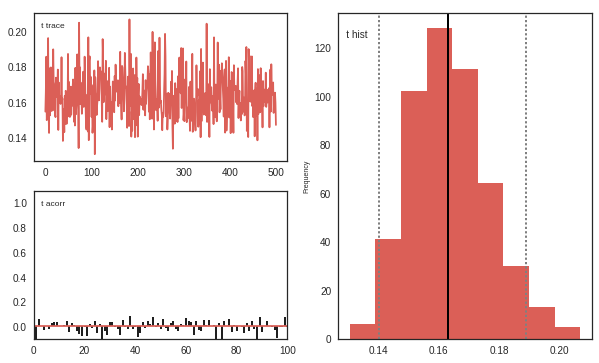

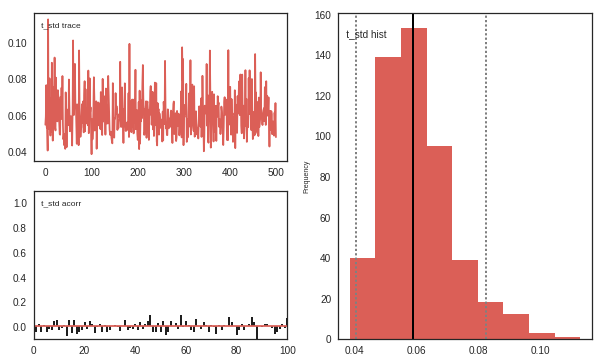

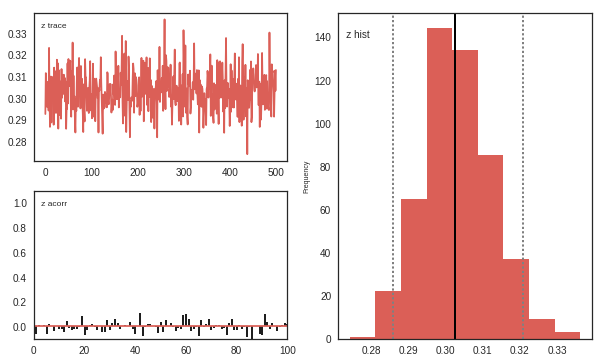

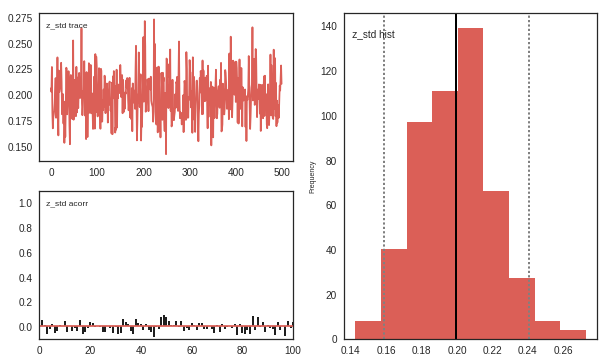

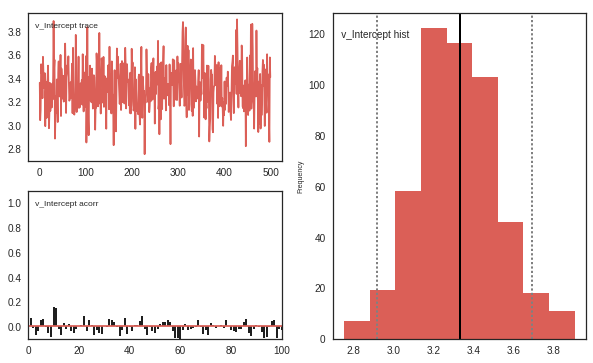

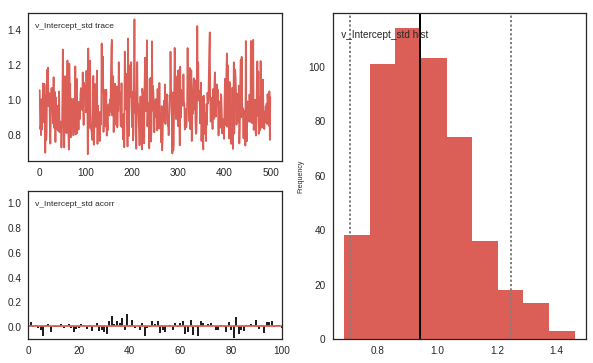

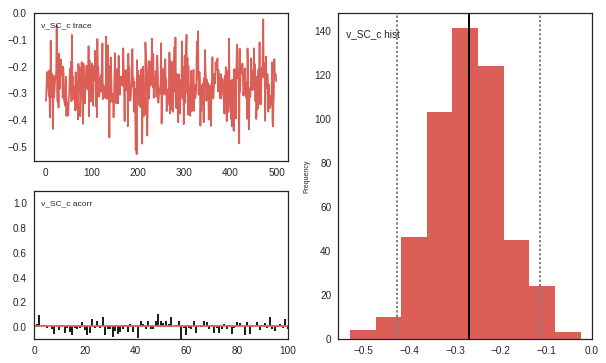

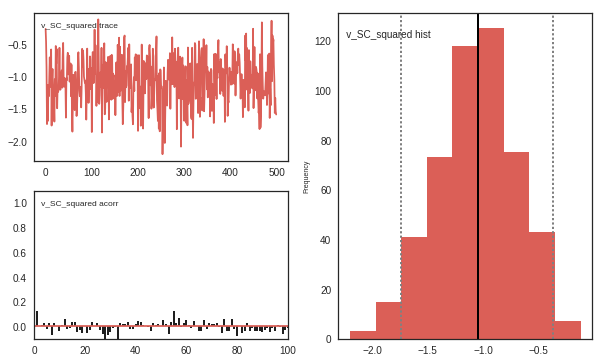

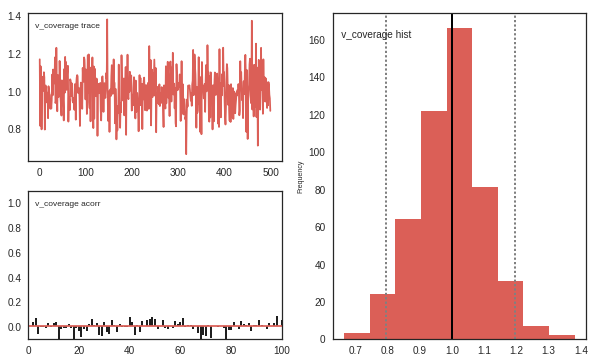

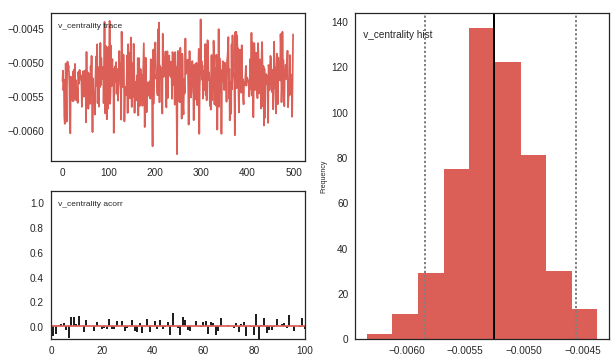

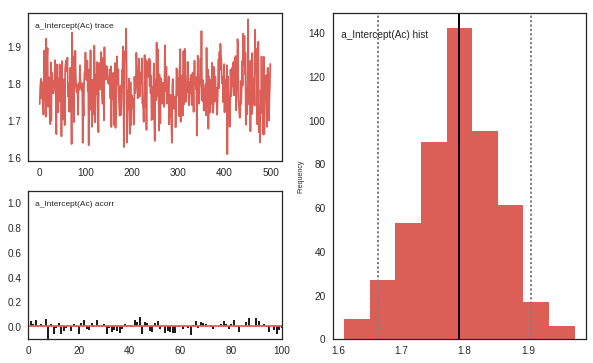

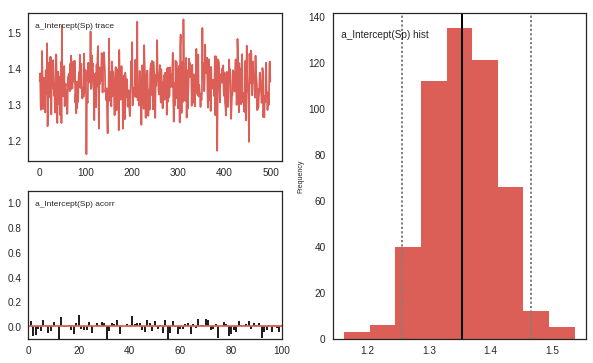

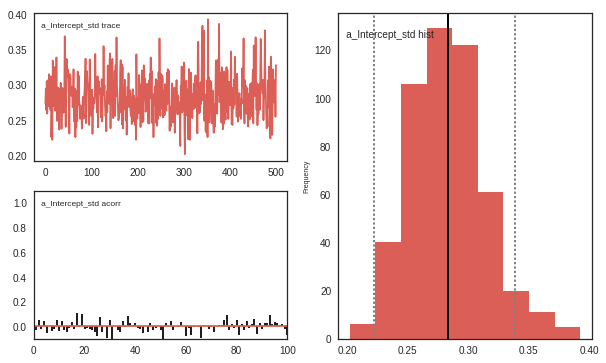

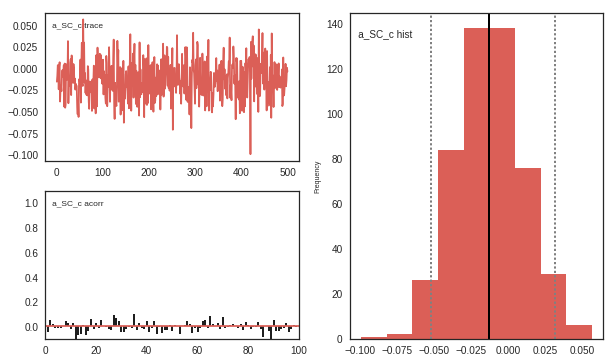

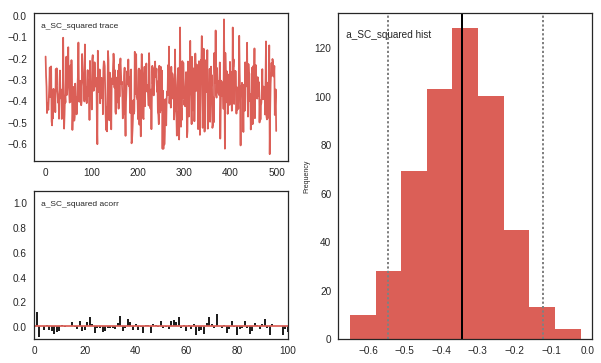

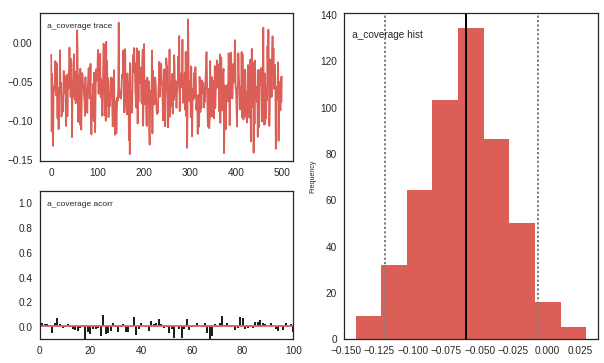

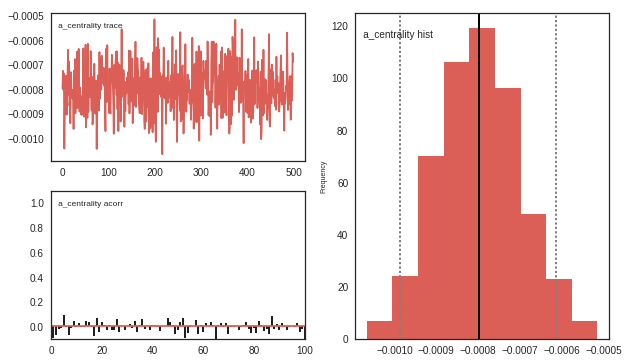

In [15]:

data = hddm.load_csv('/home/Projects/scenestats/SC_allparticipants.csv')  
data = data[data['rt']>0.1]
            
reg = ['v ~ 1 + SC_c + SC_squared + coverage + centrality', 'a ~ 1 + SC_c + SC_squared + coverage + centrality']
    
os.chdir(u'/home/Projects/scenestats/context/exp2a')
m = hddm.HDDMRegressor(data, reg, depends_on={'a':'SpAc'},bias=True,include={'z'}, p_outlier=0.05)
m.find_starting_values()
m.sample(10000, burn=5000, thin=10, dbname='mtraces.db', db='pickle')

m.save('m')
m.plot_posteriors(save=True)
m.print_stats('printstats.txt')


In [16]:
os.chdir(u'/home/Projects/scenestats/context/exp2a')
model = hddm.load('m')
model.dic

-15065.849826221514

[0.0, 0.0, 0.0, 0.0, 0.30199999999999999, 0.0, 0.0, 0.02]


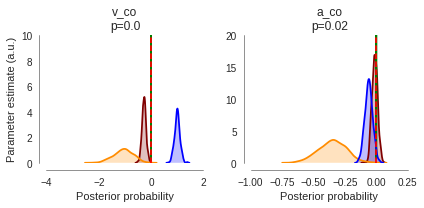

In [18]:
fig_dir = u'/home/Projects/scenestats/context/exp2a'
params_of_interest = ['v_SC_c', 'v_SC_squared', 'v_centrality', 'v_coverage', 'a_SC_c', 'a_SC_squared', 'a_centrality', 'a_coverage']
titles = ['v ~ SC', 'v ~ SC2', 'v_cent', 'v_co', 'a ~ SC', 'a ~ SC2', 'a_cent', 'a_co']

traces = []
for p in range(len(params_of_interest)):
    traces.append(model.nodes_db.node[params_of_interest[p]].trace.gettrace())

stats = []
for p in range(len(params_of_interest)):
    stat = min(np.mean(traces[p] > 0), np.mean(traces[p] < 0))
    stats.append(min(stat, 1-stat))
#stats = np.array(stats)    

print stats
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

ax_nr = 0
pl = 0
cc=['maroon','darkorange', 'green', 'blue', 'maroon', 'darkorange', 'green', 'blue']
for p in range(len(params_of_interest)):
    data = [traces[p]]
    ax = axes[ax_nr]
    for d, label, c in zip(data, ['1',], ['black']):
        sns.kdeplot(d, vertical=False, shade=True, color=cc[pl], ax=ax)
        ax.set_xlabel('Posterior probability')
        ax.set_title('{}\np={}'.format(titles[pl], round(stats[p],3)))
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
            ax.tick_params(width=0.5)          
        pl+=1
        if pl == 4:
            ax_nr+=1

        
sns.despine(offset=7, trim=False)
axes[0].set_ylabel('Parameter estimate (a.u.)')
axes[0].axvline(x=0, color='r', linestyle='--')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[0].set_ylim(0,10)
axes[0].set_xlim(-4,2)
axes[1].set_ylim(0,20)
axes[1].set_xlim(-1,0.25)

plt.tight_layout()
fig.savefig(os.path.join(fig_dir, 'posteriors.pdf'))